In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential,layers,Model
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array,load_img
from os import listdir, walk
from os.path import isfile, join
import matplotlib.pyplot as plt

In [3]:
from keras.utils.np_utils import to_categorical 

Using TensorFlow backend.


In [4]:
from keract import get_activations,display_activations

In [9]:
from keras.preprocessing import image
import cv2
from keras import backend as K
from tensorflow.keras.models import load_model
model = load_model('vgg19-fullyconnected-lr0.001.h5', custom_objects={'leaky_relu': tf.nn.leaky_relu})

In [6]:
#  !wget --no-check-certificate \
#  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
#  -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
from tensorflow.keras.applications.vgg19 import preprocess_input

In [91]:
 from tensorflow.keras.applications.vgg19 import VGG19


local_weights_file = 'vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = VGG19(input_shape = (150, 150, 3), 
                                include_top = False,    
                                weights = None)

pre_trained_model.load_weights(local_weights_file)


for layer in pre_trained_model.layers:
    layer.trainable = False

In [92]:
last_layer = pre_trained_model.get_layer('block5_pool')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 4, 4, 512)


In [11]:
#For Generatting more images from training
#Training Images were generated using the commented parameters.
datagen = ImageDataGenerator(
    
        #rotation_range=180,

        #width_shift_range=0.1,

        #height_shift_range=0.1,

        rescale=1./255,

        # shear_range=0.5,

        # zoom_range=0.5,

        # horizontal_flip=True,
        
       # fill_mode='nearest'
       )

In [90]:
#TRAINING FILES GENERATOR 

files= []
dirs = []
i = 0
for (dirpath, dirnames, filenames) in walk("train/"):
    if i == 0:
        i = 1
        continue
    img = load_img(dirpath+"/"+str(filenames[0]))
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    for batch in datagen.flow(x, batch_size=1,
                            save_to_dir=dirpath,save_prefix='gen', save_format='jpg'):
        if i<41:
            i+=1
        else:
            break
#print(i)

In [12]:
train_images = datagen.flow_from_directory("train/",
                                            class_mode="categorical",
                                            batch_size=10,
                                            target_size=(150,150))
validation_images = datagen.flow_from_directory("test/",
                                            class_mode="categorical",
                                            #batch_size=10,
                                            target_size=(150,150))

Found 420 images belonging to 10 classes.
Found 10 images belonging to 10 classes.


In [94]:
# Created a Custom Model

x = layers.Flatten()(last_output)

x = layers.Dense(1024, activation=tf.nn.leaky_relu)(x)

x = layers.Dropout(0.2)(x)        

x = layers.Dense(512,  activation = tf.nn.leaky_relu)(x)

x =  layers.Dropout(0.25)(x)
# sigmoid layer for classification (0-9 10 classes)
x = layers.Dense  (10, activation='softmax')(x)           

model = Model( pre_trained_model.input, x) 



In [95]:
model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])


model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

In [96]:
#Custom Callback Function
class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.92):
      print("\nReached 92% accuracy so cancelling training!")
      self.model.stop_training = True

In [97]:
callbacks = myCallback()
history = model.fit(train_images,
                              validation_data = validation_images,
                              steps_per_epoch = 21,
                              epochs=100,
                             # validation_steps=29,
                              verbose=1,
                              callbacks = [callbacks]
          )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 21 steps, validate for 1 steps
Epoch 1/100
21/21 [==============================] - 28s 1s/step - loss: 4.7333 - acc: 0.2476 - val_loss: 1.9463 - val_acc: 0.2000
Epoch 2/100
21/21 [==============================] - 22s 1s/step - loss: 1.9266 - acc: 0.4524 - val_loss: 0.4806 - val_acc: 1.0000
Epoch 3/100
21/21 [==============================] - 20s 975ms/step - loss: 1.1968 - acc: 0.6286 - val_loss: 1.0037 - val_acc: 0.6000
Epoch 4/100
21/21 [==============================] - 20s 975ms/step - loss: 0.9535 - acc: 0.7095 - val_loss: 0.9784 - val_acc: 0.8000
Epoch 5/100
21/21 [==============================] - 20s 945ms/step - loss: 0.7169 - acc: 0.7571 - val_loss: 0.1886 - val_acc: 1.0000
Epoch 6/100
21/21 [==============================] - 21s 1s/step - loss: 0.4435 - acc: 0.8619 - val_loss: 0.2366 - val_acc: 0.9000
Epoch 7/100
21/21 [==============================] - 20s 948ms/step - loss: 0.5615 - acc: 0.8381 - val_loss: 0.436

In [13]:
train_labels = train_images.labels
num_classes = len(train_images.class_indices) 
train_labels = to_categorical(train_labels ,num_classes = num_classes)
train_images.class_indices 

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [98]:
model.save('vgg19-fullyconnected-lr0.001.h5')

[]

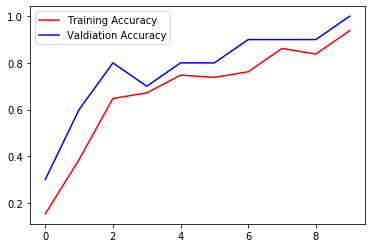

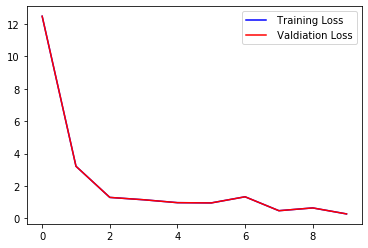

In [23]:
#Transfer Learning on VGG19. LAYERS FREEZED AND FINAL LAYER TRAINED FOR !00 EPOCHS. LEARNING RATE AT 0.002

import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
#val_acc = history.history['val_accuracy']
loss = history.history['loss']
#val_loss = history.history['val_loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Valdiation Accuracy')
plt.legend(loc=0)
plt.figure()
plt.plot(epochs, loss, 'b', label = ' Training Loss' )
plt.plot(epochs, loss, 'r', label = ' Valdiation Loss' )
plt.legend(loc=0)
plt.plot()
#model.summary()
#model.save('vgg_fully_connected_lr0.02_v1.h5')

[]

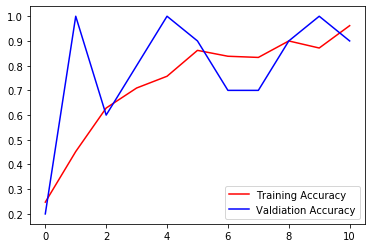

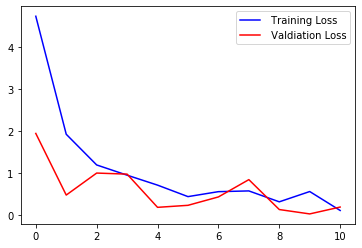

In [100]:
#####THIS IS THE CURRENT MODEL
######VGG19 FULLY CONNECTED. LEAERNING RATE 0.001. STOPPING CONDITION ACC>92
##MAYBE THE LEARNING RATE IS STILL TOO HIGH
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Valdiation Accuracy')
plt.legend(loc=0)
plt.figure()
plt.plot(epochs, loss, 'b', label = ' Training Loss' )
plt.plot(epochs, val_loss, 'r', label = ' Valdiation Loss' )
plt.legend(loc=0)
plt.plot()

In [26]:
#CREATING A REVERSE INDEX
rev_index = {}
for items in train_images.class_indices.items() :
  rev_index[items[1]] = items[0]
print(rev_index)

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9'}


In [63]:
#TESTING IMAGES
path = 'IMG_20200421_114858.jpg'
img = image.load_img(path, target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = model.predict(images) 
print(classes)
c = np.argmax(classes)
print(c, rev_index[c])

[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


NameError: name 'rev_index' is not defined

In [18]:
#VISUALIZING THE CNN
outputs = [layer.output for layer in model.layers[1:18]]

# Define a new model that generates the above output
vis_model = Model(model.input, outputs)

# check if we have all the layers we require for visualization 
vis_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [19]:
layer_names = []
for layer in outputs:
    layer_names.append(layer.name.split("/")[0])

    
print("Layers going to be used for visualization: ")
print(layer_names)

Layers going to be used for visualization: 
['block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_conv4', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_conv4', 'block4_pool', 'block5_conv1']


In [54]:
def get_CAM(processed_image, predicted_label):
    """
    This function is used to generate a heatmap for a sample image prediction.
    
    Args:
        processed_image: any sample image that has been pre-processed using the 
                       `preprocess_input()`method of a keras model
        predicted_label: label that has been predicted by the network for this image
    
    Returns:
        heatmap: heatmap generated over the last convolution layer output 
    """
    # we want the activations for the predicted label
    predicted_output = model.output[:, predicted_label]
    
    # choose the last conv layer in your model
    last_conv_layer = model.get_layer('block5_conv1')
    
    # get the gradients wrt to the last conv layer
    grads = K.gradients(predicted_output, last_conv_layer.output)[0]
    
    # take mean gradient per feature map
    grads = K.mean(grads, axis=(0,1,2))
    
    # Define a function that generates the values for the output and gradients
    evaluation_function = K.function([model.input], [grads, last_conv_layer.output[0]])
    
    # get the values
    grads_values, conv_ouput_values = evaluation_function([processed_image])
    
    # iterate over each feature map in yout conv output and multiply
    # the gradient values with the conv output values. This gives an 
    # indication of "how important a feature is"
    for i in range(512): # we have 512 features in our last conv layer
        conv_ouput_values[:,:,i] *= grads_values[i]
    
    # create a heatmap
    heatmap = np.mean(conv_ouput_values, axis=-1)
    
    # remove negative values
    heatmap = np.maximum(heatmap, 0)
    
    # normalize
    heatmap /= heatmap.max()
    
    return heatmap

(150, 150)


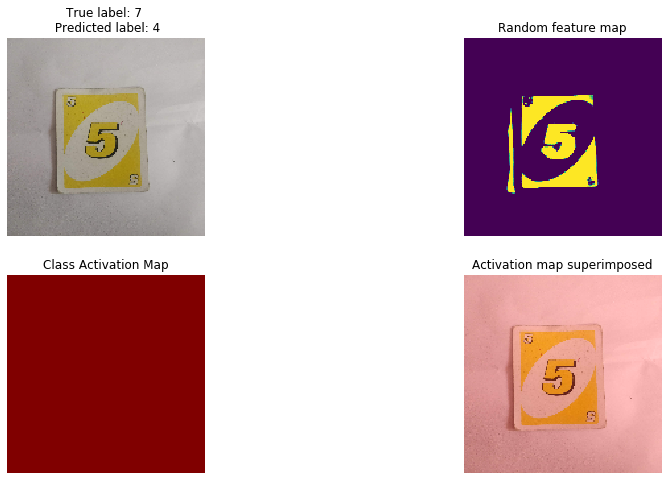

[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [64]:
sample_image = cv2.imread(path)#(valid_df.iloc[idx]['image'])
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
sample_image = cv2.resize(sample_image, (150,150))
#sample_label = valid_df.iloc[idx]["label"]

# pre-process the image
sample_image_processed = np.expand_dims(sample_image, axis=0)
sample_image_processed = preprocess_input(sample_image_processed)

# generate activation maps from the intermediate layers using the visualization model
activations = vis_model.predict(sample_image_processed)

# get the label predicted by our original model
pred_label = np.argmax(model.predict(sample_image_processed), axis=-1)[0]

# choose any random activation map from the activation maps 
sample_activation = activations[0][0,:,:,32]

# normalize the sample activation map
sample_activation-=sample_activation.mean()
sample_activation/=sample_activation.std()

# convert pixel values between 0-255
sample_activation *=255
sample_activation = np.clip(sample_activation, 0, 255).astype(np.uint8)



# get the heatmap for class activation map(CAM)
heatmap = get_CAM(sample_image_processed, pred_label)
heatmap = cv2.resize(heatmap, (sample_image.shape[0], sample_image.shape[1]))
print((sample_image.shape[0], sample_image.shape[1]))
heatmap = heatmap *255
heatmap = np.clip(heatmap, 0, 255).astype(np.uint8)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
f,ax = plt.subplots(2,2, figsize=(15,8))
ax[1,0].imshow(heatmap)
ax[1,0].set_title("Class Activation Map")
ax[1,0].axis('off')
super_imposed_image = heatmap * 0.5 + sample_image
super_imposed_image = np.clip(super_imposed_image, 0,255).astype(np.uint8)
ax[0,0].imshow(sample_image)
ax[0,0].set_title(f"True label: 7 \n Predicted label: {pred_label}")
ax[0,0].axis('off')

ax[0,1].imshow(sample_activation)
ax[0,1].set_title("Random feature map")
ax[0,1].axis('off')


ax[1,1].imshow(super_imposed_image)
ax[1,1].set_title("Activation map superimposed")
ax[1,1].axis('off')
plt.show()
#print(model.predict(sample_image_processed))

(150, 150)


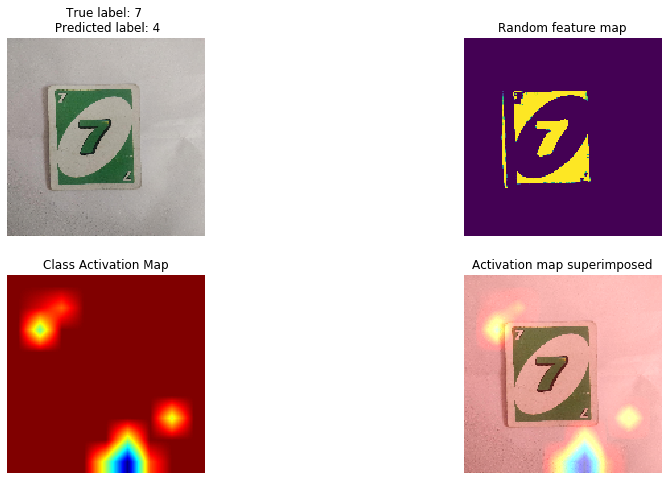

[[0.0000000e+00 0.0000000e+00 2.6686205e-06 7.7827194e-34 9.9999738e-01
  6.4875974e-32 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]]


In [68]:
#SMALL AREAS LIGHTUP IN SOME IMAGES
path1 = 'IMG_20200421_114759.jpg'
sample_image = cv2.imread(path1)#(valid_df.iloc[idx]['image'])
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
sample_image = cv2.resize(sample_image, (150,150))
#sample_label = valid_df.iloc[idx]["label"]

# pre-process the image
sample_image_processed = np.expand_dims(sample_image, axis=0)
sample_image_processed = preprocess_input(sample_image_processed)

# generate activation maps from the intermediate layers using the visualization model
activations = vis_model.predict(sample_image_processed)

# get the label predicted by our original model
pred_label = np.argmax(model.predict(sample_image_processed), axis=-1)[0]

# choose any random activation map from the activation maps 
sample_activation = activations[0][0,:,:,32]

# normalize the sample activation map
sample_activation-=sample_activation.mean()
sample_activation/=sample_activation.std()

# convert pixel values between 0-255
sample_activation *=255
sample_activation = np.clip(sample_activation, 0, 255).astype(np.uint8)



# get the heatmap for class activation map(CAM)
heatmap = get_CAM(sample_image_processed, pred_label)
heatmap = cv2.resize(heatmap, (sample_image.shape[0], sample_image.shape[1]))
print((sample_image.shape[0], sample_image.shape[1]))
heatmap = heatmap *255
heatmap = np.clip(heatmap, 0, 255).astype(np.uint8)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
f,ax = plt.subplots(2,2, figsize=(15,8))
ax[1,0].imshow(heatmap)
ax[1,0].set_title("Class Activation Map")
ax[1,0].axis('off')
super_imposed_image = heatmap * 0.5 + sample_image
super_imposed_image = np.clip(super_imposed_image, 0,255).astype(np.uint8)
ax[0,0].imshow(sample_image)
ax[0,0].set_title(f"True label: 7 \n Predicted label: {pred_label}")
ax[0,0].axis('off')

ax[0,1].imshow(sample_activation)
ax[0,1].set_title("Random feature map")
ax[0,1].axis('off')


ax[1,1].imshow(super_imposed_image)
ax[1,1].set_title("Activation map superimposed")
ax[1,1].axis('off')
plt.show()
print(model.predict(sample_image_processed))

In [65]:
#VISUALIZING EACH FEATURE MAP. TO CHECK IF ACTIVATION LAYER IS NOT WORKING
sample_image = cv2.imread(path)#(valid_df.iloc[idx]['image'])
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
sample_image = cv2.resize(sample_image, (150,150))
#sample_label = valid_df.iloc[idx]["label"]

# pre-process the image
sample_image_processed = np.expand_dims(sample_image, axis=0)
sample_image_processed = preprocess_input(sample_image_processed)
activations = get_activations(model, sample_image_processed,'block5_conv1')

block5_conv1 (1, 9, 9, 512) 


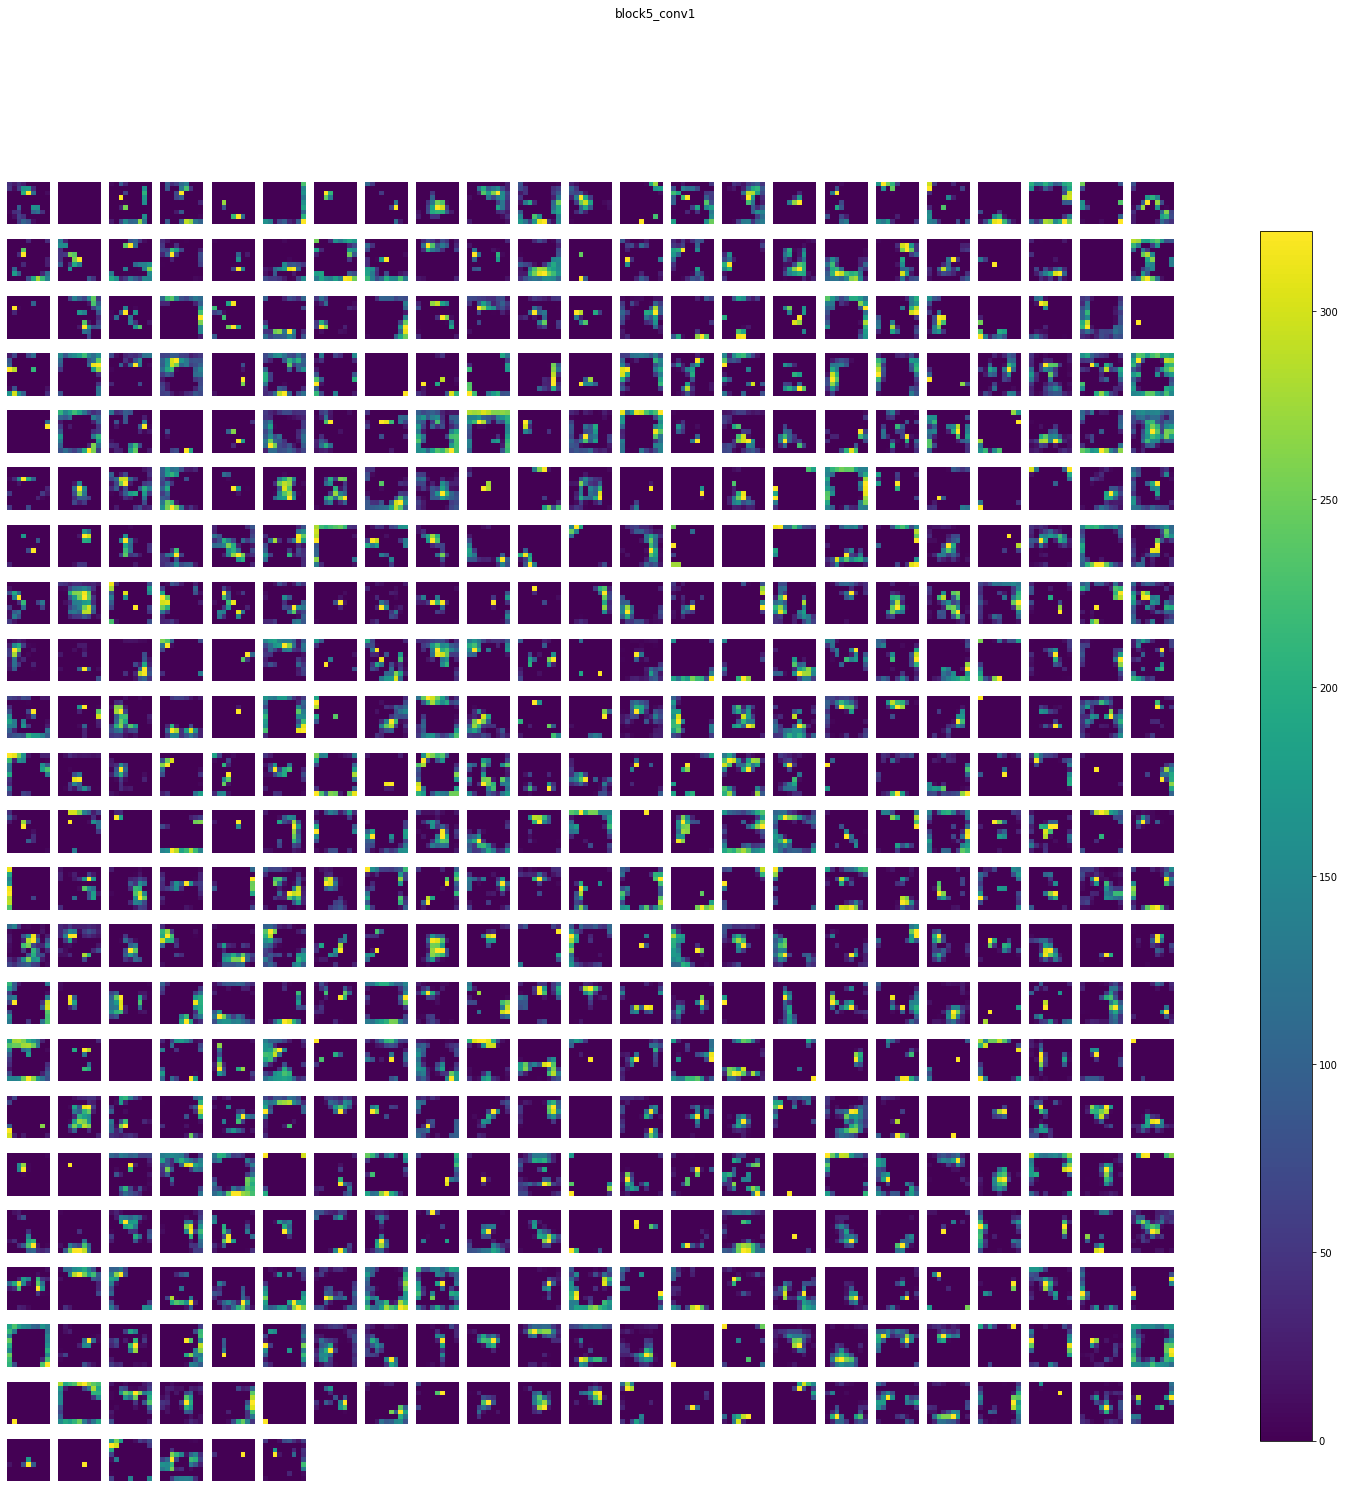

In [66]:
display_activations(activations, save=False)